In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#CCL
import pyccl as ccl

In [3]:
# Colossus
from colossus.cosmology import cosmology as col_cosmo

In [4]:
# Colossus Cosmology
cosmo_col = col_cosmo.setCosmology('planck18'); # no massive neutrinos

Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0
n_s_col     = cosmo_col.ns

# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c_col, Omega_b=Omega_b_col, h=h_col, sigma8=cosmo_col.sigma8, n_s=n_s_col)


In [5]:
print(cosmo_col)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [6]:
print(cosmo_ccl)

pyccl.Cosmology(Omega_c=0.2621, Omega_b=0.049, h=0.6766, n_s=0.9665, sigma8=0.8102, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


In [7]:
Delta = 200
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.2
a     = 1.0 / (1.0 + z)

# CCL
MDEF               = 'matter'
mdef               = ccl.halos.MassDef (Delta, MDEF)
conc               = ccl.halos.ConcentrationConstant(cvir)
mdef.concentration = conc

ccl_nfw_num            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = False, 
                                               cumul2d_analytic = False)
ccl_nfw_ana            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = True, 
                                               cumul2d_analytic = True)

In [8]:
ccl_nfw_num.precision_fftlog

{'padding_lo_fftlog': 0.01,
 'padding_lo_extra': 0.1,
 'padding_hi_fftlog': 100.0,
 'padding_hi_extra': 10.0,
 'large_padding_2D': False,
 'n_per_decade': 1000,
 'extrapol': 'linx_liny',
 'plaw_fourier': -2.0,
 'plaw_projected': -1.0}

In [9]:
ccl_nfw_num.update_precision_fftlog (large_padding_2D = True)

In [10]:
r= 10**np.arange (0, 4, 0.02) * 1.0e-3 # Mpc - physical

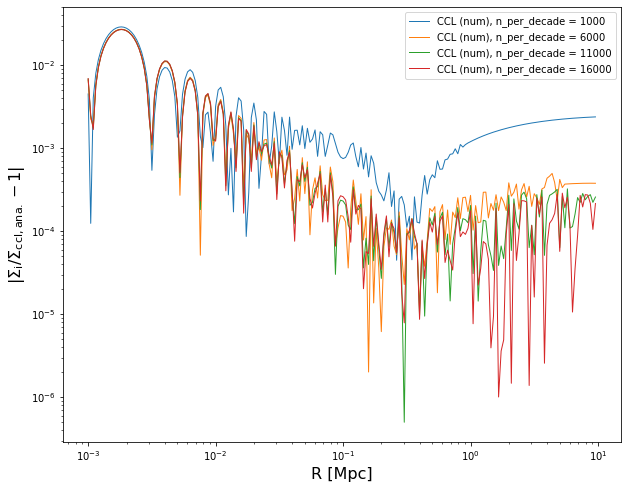

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')  
ax.set_xlabel('R [Mpc]', fontsize=16)
ax.set_ylabel(r'$|\Sigma_{\mathrm{i}} / \Sigma_{\mathrm{ccl, ana.}} - 1|$', fontsize=16)

for n in np.arange(1000,20000,5000):
    ccl_nfw_num.update_precision_fftlog (n_per_decade = n)
#    ccl_nfw_num.update_precision_fftlog (plaw_fourier = -2)


# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num), n_per_decade = "+str(n), lw=1)

ax.legend()
    

In [12]:
ccl_nfw_num.precision_fftlog

{'padding_lo_fftlog': 0.01,
 'padding_lo_extra': 0.1,
 'padding_hi_fftlog': 100.0,
 'padding_hi_extra': 10.0,
 'large_padding_2D': True,
 'n_per_decade': 16000,
 'extrapol': 'linx_liny',
 'plaw_fourier': -2.0,
 'plaw_projected': -1.0}

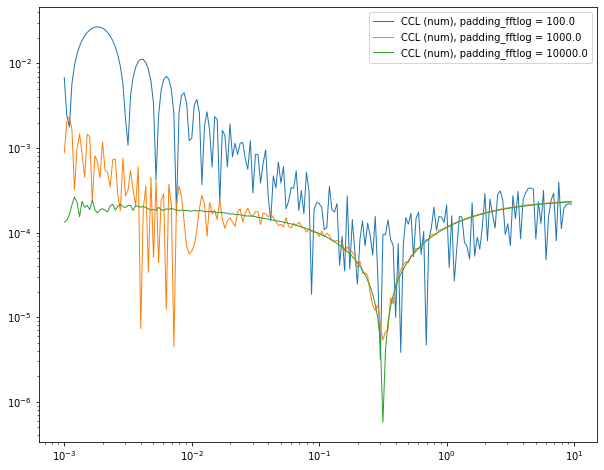

In [19]:
#reset n_per_decade to default
#ccl_nfw_num.update_precision_fftlog (n_per_decade = 1000) # default
ccl_nfw_num.update_precision_fftlog (n_per_decade = 10000)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')    
for fact in np.logspace(2,4,3):
    ccl_nfw_num.update_precision_fftlog (padding_lo_fftlog=1./fact)
    ccl_nfw_num.update_precision_fftlog (padding_hi_fftlog=fact)


# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num), padding_fftlog = "+str(fact), lw=1)

ax.legend()

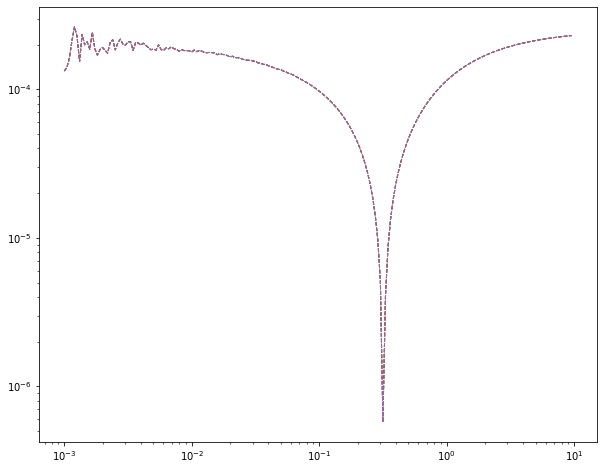

In [20]:
#reset padding to default
# ccl_nfw_num.update_precision_fftlog (padding_lo_fftlog = 0.01)
# ccl_nfw_num.update_precision_fftlog (padding_hi_fftlog = 100)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')    
for fact in np.logspace(1,3,5):
    ccl_nfw_num.update_precision_fftlog (padding_lo_extra=1./fact)
    ccl_nfw_num.update_precision_fftlog (padding_hi_extra=fact)


# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num)", linestyle='--', lw=1)


linx_liny
linx_logy
logx_logy


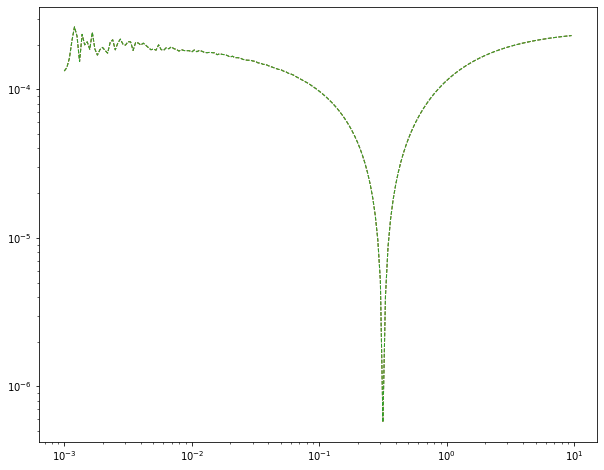

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')    
for ep in ['linx_liny','linx_logy','logx_logy']:
    ccl_nfw_num.update_precision_fftlog (extrapol=ep)
    print(ep)

# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num)", linestyle='--', lw=1)


-1.5
-1.0
-0.5


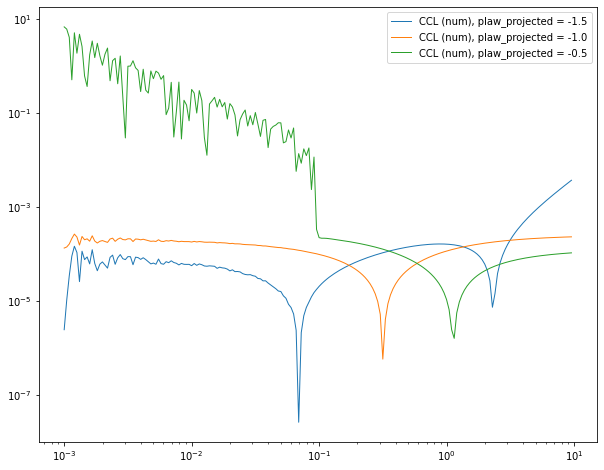

In [22]:
# ccl_nfw_num.update_precision_fftlog (padding_lo_fftlog=0.0001)
# ccl_nfw_num.update_precision_fftlog (padding_hi_fftlog=10000)
ccl_nfw_num.update_precision_fftlog (extrapol='linx_liny')
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')    
for p in [-1.5,-1., -0.5]:
    print(p)
    ccl_nfw_num.update_precision_fftlog (plaw_projected=p)

# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num), plaw_projected = "+str(p), lw=1)
ax.legend()


-2.0
-1.5
-1.0


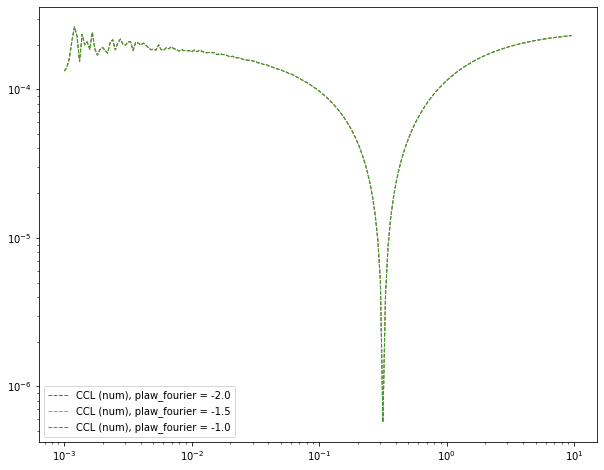

In [23]:
# ccl_nfw_num.update_precision_fftlog (padding_lo_fftlog=0.01)
# ccl_nfw_num.update_precision_fftlog (padding_hi_fftlog=1.e2)
ccl_nfw_num.update_precision_fftlog (plaw_projected=-1)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
ax.set_xscale ('log')
ax.set_yscale ('log')    
for p in [-2.,-1.5,-1.]:
    print(p)
    ccl_nfw_num.update_precision_fftlog (plaw_fourier=p)

# CCL
    ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
    ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

    ax.plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num), plaw_fourier = "+str(p), linestyle='--', lw=1)
ax.legend()
